In [7]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Activation,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

(281, 300, 3)


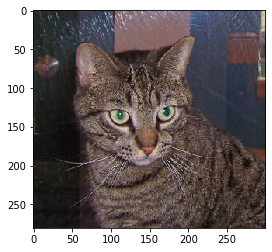

In [8]:
#Load a test image 
img_path = "kagglecatsanddogs_3367a/PetImages/"
img = image.load_img(img_path+"Cat/1.jpg")
plt.imshow(img)


print(cv2.imread(img_path+"Cat/1.jpg").shape) #Color image
# plt.imshow(cv2.imread(img_path+"Cat/997.jpg", cv2.IMREAD_GRAYSCALE), cmap="gray")  #B&W IMAGE

In [3]:
#Load Data

import os
import random

category = ["Dog","Cat"]
imgsize = 100
train_dataset = []
for c in category:
    print("Starting ",c)
    path = os.path.join(img_path,c)
    for i in os.listdir(path):
        try:
            temp=cv2.imread(os.path.join(path,i))
            new=cv2.resize(temp,(imgsize,imgsize))
            train_dataset.append([new,category.index(c)])
        except Exception as e:  #Some images could be corrupt
            pass

print(len(train_dataset))

Starting  Dog
Starting  Cat
24946


In [4]:
#Shuffle Dataset
random.shuffle(train_dataset)   
for i in train_dataset[:10]:
    print(i[1])    # Test out shuffling

    
    
#Separate out features and lables 

X=[]
y=[]
for features,label in train_dataset:
    X.append(features)
    y.append(label)
    
    
#Convert feature list into array and noramalize 

X = np.array(X).reshape(-1,imgsize,imgsize,3)  # -1 denotes all the elements in X
X = X/255.0 

0
1
1
1
1
1
0
0
0
0


In [5]:
X.shape[1:]

(100, 100, 3)

In [99]:
#Load Dataset (Alternative Way)

"""
#Remove corrupt images

corrupt=[]
category = ["Dog","Cat"]
for c in category:
  print("Starting ",c)
  path = os.path.join(img_path,c)
  for i in os.listdir(path):
    try:
      k=cv2.imread(os.path.join(path,i),cv2.IMREAD_GRAYSCALE)
      cv2.resize(k,(50,50))
    except Exception as e:
      corrupt.append(c+"/"+i)

for i in corrupt:
    os.remove(img_path+i)

"""

dataGenerator = ImageDataGenerator(rescale=1/255,   #Normalize between 0 to 1, as image px range 0-255
                                   rotation_range=180,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.20)     
imgsize = 150
# This will auto generate labels based on directory
train_dataset = dataGenerator.flow_from_directory(img_path,  
                                          target_size=(imgsize,imgsize),  #To bring all image to same size
                                          batch_size = 32,
                                          #color_mode="grayscale",
                                          shuffle=True,
                                          subset="training",
                                          class_mode="binary")    # Selecting categorical can stuck accuracy at 50%

validation_dataset = dataGenerator.flow_from_directory(img_path,  
                                          target_size=(imgsize,imgsize),  #To bring all image to same size
                                          batch_size = 32,
                                          #color_mode="grayscale",
                                          shuffle=True,
                                          subset="validation",
                                          class_mode="binary")

print(train_dataset.class_indices)
print(validation_dataset.class_indices)

Found 19957 images belonging to 2 classes.
Found 4989 images belonging to 2 classes.
{'Cat': 0, 'Dog': 1}
{'Cat': 0, 'Dog': 1}


In [100]:
model = Sequential()

#1st Layer
model.add(Conv2D(32,(3,3), padding="same",input_shape=(imgsize,imgsize,3)))
model.add(Activation('relu'))

#model.add(Conv2D(32,(3,3), padding="same"))
#model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#3rd 
model.add(Conv2D(64,(3,3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#4th 
model.add(Conv2D(64,(3,3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#5th 
model.add(Conv2D(128,(3,3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))


#6th Layer
model.add(Flatten())

#7th Layer
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dropout(0.5))

#8th 
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.5))

#9th 
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.3))

#10th 
model.add(Dense(1, activation="sigmoid"))



In [101]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_126 (Conv2D)          (None, 150, 150, 32)      896       
_________________________________________________________________
activation_192 (Activation)  (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 75, 75, 64)        18496     
_________________________________________________________________
activation_193 (Activation)  (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 37, 37, 64)      

In [102]:
# checkpoint
filepath="weights_rot180.best.hdf5"  # serialize best model weight to HDF5
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


model_fit = model.fit(train_dataset, 
                      batch_size=100, 
                      epochs=25, 
                      callbacks=callbacks_list,
                      validation_data= validation_dataset)


Epoch 1/25
624/624 [==============================] - ETA: 0s - loss: 0.6895 - accuracy: 0.5383
Epoch 00001: val_accuracy improved from -inf to 0.56885, saving model to weights_rot180.best.hdf5
624/624 [==============================] - 451s 722ms/step - loss: 0.6895 - accuracy: 0.5383 - val_loss: 0.6829 - val_accuracy: 0.5689
Epoch 2/25
624/624 [==============================] - ETA: 0s - loss: 0.6860 - accuracy: 0.5439
Epoch 00002: val_accuracy did not improve from 0.56885
624/624 [==============================] - 484s 776ms/step - loss: 0.6860 - accuracy: 0.5439 - val_loss: 0.6787 - val_accuracy: 0.5689
Epoch 3/25
624/624 [==============================] - ETA: 0s - loss: 0.6817 - accuracy: 0.5726
Epoch 00003: val_accuracy improved from 0.56885 to 0.59351, saving model to weights_rot180.best.hdf5
624/624 [==============================] - 466s 746ms/step - loss: 0.6817 - accuracy: 0.5726 - val_loss: 0.6742 - val_accuracy: 0.5935
Epoch 4/25
624/624 [==============================] -

In [103]:
# serialize model to JSON for future ref

json_file = model.to_json()
with open("serializedModel_rot180.json", "w") as file:
    file.write(json_file)
    
#Serialize weights to HDF5
    #Currently Done while checkpointing
    #model.save_weights(h5_file)
 

In [104]:
#Load Model: Code Snippet

from tensorflow.keras.models import model_from_json

# load json and create model
file = open("serializedModel_rot180.json", 'r')
model_json = file.read()
file.close()
loaded_model = model_from_json(model_json)

#Load Weights
loaded_model.load_weights("weights_rot180.best.hdf5")
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# estimate accuracy on whole dataset using loaded weights
#scores = loaded_model.evaluate(validation_dataset, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], scores[1]*100))


In [111]:
#Test on sample data collected from internet

testGenerator = ImageDataGenerator(rescale=1/255)   
imgsize = 150
test_dataset = testGenerator.flow_from_directory("test/",  
                                          target_size=(imgsize,imgsize),  #To bring all image to same size
                                          batch_size = 50,
                                          class_mode="binary") 
print(test_dataset.class_indices)

# estimate accuracy on test dataset
scores = loaded_model.evaluate(test_dataset, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], scores[1]*100))

Found 11 images belonging to 2 classes.
{'Cat': 0, 'Dog': 1}
accuracy: 90.91%
